<a href="https://colab.research.google.com/github/Ash100/Minor/blob/main/Conformational_Changes_DCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ACCESSING CONFORMATIONAL CHANGES IN SIMULATION TRAJECTORIES

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
# After restart, install analysis tools
!mamba install -y mdanalysis mdtraj nglview MDAnalysisTests

In [ ]:
!pip install --upgrade MDAnalysis MDTraj nglview

In [2]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
!{sys.executable} -m pip install --upgrade MDAnalysis MDTraj

# Force the system to see the new installation immediately
import site
from importlib import reload
reload(site)

# Final check
try:
    import MDAnalysis as mda
    print(f"✅ SUCCESS: MDAnalysis {mda.__version__} is ready.")
except ImportError:
    print("❌ Critical Error: The environment is locked. Go to 'Runtime' -> 'Disconnect and delete runtime', then run ONLY this cell.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 4.1 MB/s eta 0:00:00
  Using cached GridDataFormats-1.0.2-py3-none-any.whl.metadata (4.9 kB)
  Using cached mmtf_python-1.1.3-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached mda_xdrlib-0.2.0-py3-none-any.whl.metadata (19 kB)
  Using cached mrcfile-1.5.4-py2.py3-none-any.whl.metadata (7.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 145.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 139.4 MB/s eta 0:00:00
Using cached GridDataFormats-1.0.2-py3-none-any.whl (2.1 MB)
Using cached mmtf_python-1.1.3-py2.py3-none-any.whl (25 kB)
Using cached mda_xdrlib-0.2.0-py3-none-any.whl (14 kB)
Using cached mrcfile-1.5.4-py2.py3-none-any.whl (45 kB)
✅ SUCCESS: MDAnalysis 2.10.0 is ready.


In [5]:
import sys
import MDAnalysis as mda
print(mda.__version__)

2.10.0


/usr/local/lib/python3.12/dist-packages/MDAnalysis/topology/PDBParser.py:309: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "
/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


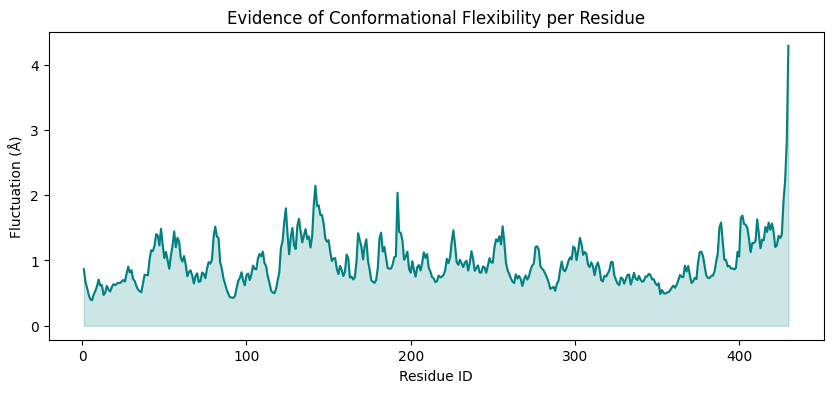

In [72]:
# 1. Load Universe
# Selection 'protein' automatically ignores HETATM (waters/ions)
u = mda.Universe("/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_equil.pdb", "/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_prod1-10_whole.dcd")
protein = u.select_atoms("protein")

# 2. RMSF: To see WHERE the change is happening
from MDAnalysis.analysis.rms import RMSF
calphas = protein.select_atoms("name CA")
rmsfer = RMSF(calphas).run()

# 3. Visualization of Change
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(calphas.resids, rmsfer.results.rmsf, color='teal', lw=1.5)
plt.fill_between(calphas.resids, rmsfer.results.rmsf, color='teal', alpha=0.2)
plt.title("Evidence of Conformational Flexibility per Residue")
plt.xlabel("Residue ID")
plt.ylabel("Fluctuation (Å)")
plt.show()

In [73]:
import mdtraj as md
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# 1. Load the trajectory (Using the correct argument)
# We load only the protein atoms to ensure HETATM don't bias the clustering
top_full = md.load_pdb("/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_equil.pdb")
selection = top_full.topology.select("protein")

# Load trajectory and slice to protein-only immediately
traj = md.load("/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_prod1-10_whole.dcd", top="/content/drive/MyDrive/prof_amr/PFKC2/PFKC2_equil.pdb")
traj = traj.atom_slice(selection)

# Force ignore unitcell info to avoid the angle error
traj.unitcell_vectors = None
traj.unitcell_angles = None

# 2. Alignment (Crucial for concrete conformational analysis)
traj.superpose(traj, 0)

print(f"Analyzing {traj.n_frames} frames with {traj.n_atoms} protein atoms.")

# 3. Generate RMSD Distance Matrix
# This compares every frame to every other frame
distances = np.empty((traj.n_frames, traj.n_frames))
for i in range(traj.n_frames):
    distances[i] = md.rmsd(traj, traj, i)

# 4. Clustering into Major States
n_clusters = 3  # Adjust based on how many 'states' you suspect
clusterer = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
labels = clusterer.fit_predict(distances)

# 5. Extract Representative Structures (The Medoids)
for cluster_id in range(n_clusters):
    indices = np.where(labels == cluster_id)[0]

    # Find the frame closest to all others in the same cluster
    sub_matrix = distances[indices][:, indices]
    medoid_idx = indices[np.argmin(sub_matrix.sum(axis=1))]

    # Save the professional, cleaned structure
    traj[medoid_idx].save_pdb(f"PFKC_cluster_{cluster_id}_centroid.pdb")

    # Evidence: Calculate percentage of time spent in this state
    percentage = (len(indices) / traj.n_frames) * 100
    print(f"State {cluster_id}: {percentage:.2f}% occupancy (Frame {medoid_idx})")

Analyzing 1000 frames with 6959 protein atoms.
State 0: 39.60% occupancy (Frame 759)
State 1: 19.40% occupancy (Frame 69)
State 2: 41.00% occupancy (Frame 445)


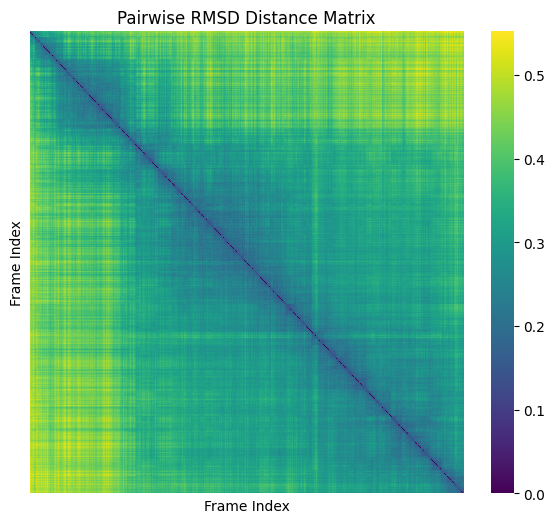

In [29]:
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.heatmap(distances, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title("Pairwise RMSD Distance Matrix")
plt.xlabel("Frame Index")
plt.ylabel("Frame Index")
# Save for manuscript
plt.savefig("FBP2_Heatmap.png", dpi=600)
plt.show()

In [56]:
# Example: Difference between State 0 and State 1
c0 = md.load("cluster_1_centroid.pdb")
c1 = md.load("cluster_2_centroid.pdb")
diff = md.rmsd(c0, c1)[0]
print(f"Conformational shift magnitude: {diff:.2f} Angstroms")

Conformational shift magnitude: 0.34 Angstroms


In [74]:
import pandas as pd

# Load all three centroids
centroids = [md.load(f"PFKC_cluster_{i}_centroid.pdb") for i in range(3)]
matrix = np.zeros((3, 3))

for i in range(3):
    for j in range(3):
        # Align j to i before calculating RMSD
        centroids[j].superpose(centroids[i])
        matrix[i, j] = md.rmsd(centroids[j], centroids[i])[0]

df_rmsd = pd.DataFrame(matrix, columns=['State 0', 'State 1', 'State 2'], index=['State 0', 'State 1', 'State 2'])
print("Inter-State RMSD Matrix (Angstroms):")
print(df_rmsd)

Inter-State RMSD Matrix (Angstroms):
          State 0   State 1   State 2
State 0  0.000000  0.200092  0.199694
State 1  0.200092  0.000000  0.193254
State 2  0.199688  0.193251  0.000000


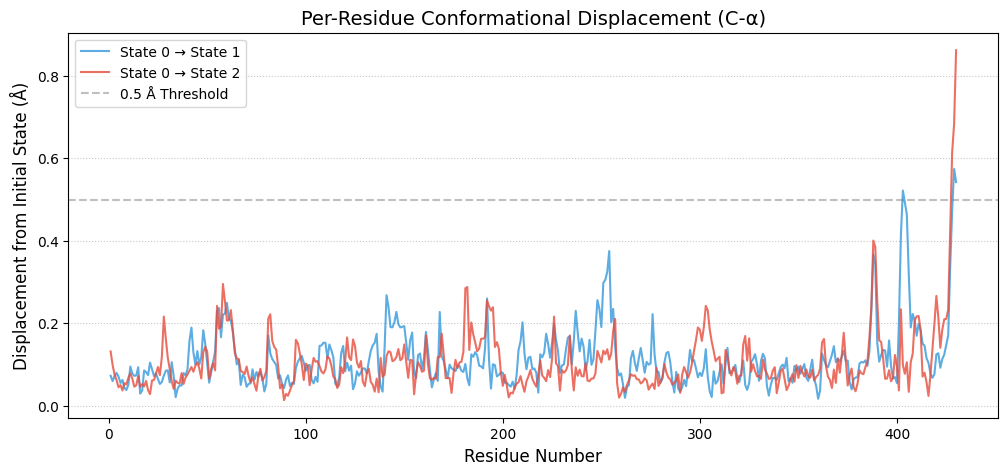

In [75]:
# 1. Align State 1 and State 2 to State 0
centroids[1].superpose(centroids[0])
centroids[2].superpose(centroids[0])

# 2. Calculate displacements relative to State 0
# State 1 vs 0
diff_01 = np.sqrt(np.sum((centroids[1].xyz - centroids[0].xyz)**2, axis=2))[0]
# State 2 vs 0
diff_02 = np.sqrt(np.sum((centroids[2].xyz - centroids[0].xyz)**2, axis=2))[0]

# 3. Create a Residue-level x-axis (more professional than Atom Index)
# We take the C-alpha indices for a cleaner plot
ca_indices = centroids[0].topology.select("name CA")
res_ids = [centroids[0].topology.atom(i).residue.resSeq for i in ca_indices]
diff_01_ca = diff_01[ca_indices]
diff_02_ca = diff_02[ca_indices]

# 4. Plotting
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(res_ids, diff_01_ca, label="State 0 → State 1", color='#3498db', alpha=0.8, lw=1.5)
plt.plot(res_ids, diff_02_ca, label="State 0 → State 2", color='#e74c3c', alpha=0.8, lw=1.5)

# Add a threshold line to show what is "significant"
# (Usually 1.0 or 1.5A, but here we use 0.5A since your protein is very stable)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label="0.5 Å Threshold")

plt.title("Per-Residue Conformational Displacement (C-α)", fontsize=14)
plt.xlabel("Residue Number", fontsize=12)
plt.ylabel("Displacement from Initial State (Å)", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.7)

# Save for manuscript
plt.savefig("PFKC_Multi_State_Displacement.png", dpi=600, bbox_inches='tight')
plt.show()